# C7 Nitrate Plots - similar style to C2 plots

see [Chukchi_Nitrate_plots](Chukchi_Nitrate_plots.ipynb) for C2 example

Requires data file with salinity, temperature, nitrates, ice concentration

Filter all data with f35 lanzcos file

Calvin compiled no3 data   
Get other data from erddap


In [16]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
from datetime import datetime, date


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import matplotlib.patches as patches
import glob

### to import filter function
import sys
try:
    # The insertion index should be 1 because index 0 is this file
    sys.path.insert(1, '/Users/bell/Programs/Python/EcoFOCI_Jupyter_Notebooks/filters')  # the type of path is string
    # because the system path already have the absolute path to folder a
    # so it can recognize file_a.py while searching 
    import lanzcos
except (ModuleNotFoundError, ImportError) as e:
    print("{} fileure".format(type(e)))
else:
    print("Import succeeded")

Import succeeded


In [25]:
server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)
# searchterm mooring... subset this later
df = pd.read_csv(e.get_search_url(response='csv', search_for='ckp-6'))
print(df['Dataset ID'].values)

['ADCP_Mooring_14ckp6a_final' 'ADCP_Mooring_13ckp6a_final'
 'datasets_Mooring_13ckp6a_final' 'datasets_Mooring_14ckp6a_final'
 'datasets_Mooring_14ckp6a_preliminary']


In [26]:
from requests.exceptions import HTTPError

l = ['final']
dfs = {}

for dataset_id in df['Dataset ID'].values:

    if any(x in dataset_id for x in l) and (not 'ADCP' in dataset_id):
        print(dataset_id)
        try:
            d = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv'
            )
            d.dataset_id=dataset_id

        except HTTPError:
            print('Failed to generate url {}'.format(dataset_id))

        try:
            df_m = d.to_pandas(
                        index_col='time (UTC)',
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )
            df_m.sort_index(inplace=True)
            df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]

            dfs.update({dataset_id:df_m})
        except:
            pass


datasets_Mooring_13ckp6a_final
datasets_Mooring_14ckp6a_final


dict_keys(['13ckp6a_ecf_0039m', '13ckp6a_sc_0039m', '13ckp6a_wcp_ein', '13ckp6a_wcp_scal', '13ckp6a_wcp_vel'])
dict_keys(['14ckp6a_sc_0039m', '14ckp6a_wcp_ein', '14ckp6a_wcp_scal', '14ckp6a_wcp_vel'])
datasets_Mooring_13ckp6a_final: 13ckp6a_ecf_0039m
datasets_Mooring_13ckp6a_final: 13ckp6a_sc_0039m
datasets_Mooring_14ckp6a_final: 14ckp6a_sc_0039m


(31.0, 34.0)

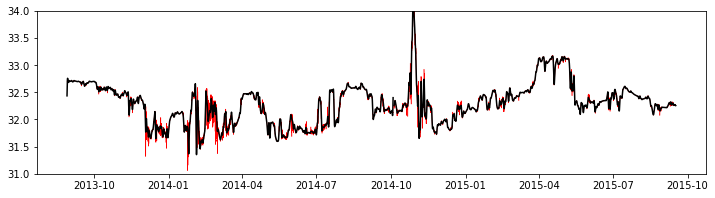

In [27]:
#filter through instruments - this is a simple mooring so only the bottom seacat/eco
for df in dfs.keys():
   print(dfs[df].groupby('timeseries_id').groups.keys())

#filter each instrument now
#group by depth
parameter_process_sc= ['temperature','salinity','PAR']
parameter_drop_sc=['Chlorophyll_Fluorescence','pressure','Oxygen_Saturation','Oxygen_Concentration','Serial_Number']
parameter_process_ecf= ['Chlorophyll_Fluorescence']
parameter_drop_ecf=['pressure','Oxygen_Saturation','Oxygen_Concentration','Serial_Number','temperature','salinity','PAR']


dfs_filtered = {}
fig, (ax1) = plt.subplots(1,1,sharex='col',figsize=(12,3))
for dfn, df in dfs.items():

    dfg = df.groupby('timeseries_id')
    
    for ds in dfg.groups:
        if ('_sc_' in ds):
            print(f"{dfn}: {ds}")
            try:
                dft = dfg.get_group(ds).drop(parameter_drop_sc,axis=1).dropna()


                for parameter in parameter_process_sc:
                    #
                    ## missing data fill limited by number of hours to linearly interpolate
                    temp = dft[parameter].interpolate(method='time',limit=6)

                    # get index of missing data that wasn't filled
                    # the remaining missing data will continue to be missing after analysis
                    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

                    missing_index = np.isnan(temp)
                    temp = dft[parameter].interpolate(method='time')

                    #address gaps at beginning and end... back fill... and forward fill at end... 
                    # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
                    temp.bfill(inplace=True)
                    temp.ffill(inplace=True)

                    #filter data with lanzcos filter
                    dft[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + dft[parameter].mean()

                    #plot
                    ax1.plot(dft.index.values, dft[parameter],'r',linewidth=.5, label=dfn)
                    ax1.plot(dft.index.values, dft[parameter+'_f35'],'k',linewidth=1.5, label=dfn)

                dfs_filtered.update({dfn+'_filtered_sc':dft})
            except:
                continue
        elif ('_ecf_' in ds):
            print(f"{dfn}: {ds}")
            try:
                dft = dfg.get_group(ds).drop(parameter_drop_ecf,axis=1).dropna()
                

                for parameter in parameter_process_ecf:
                    #
                    ## missing data fill limited by number of hours to linearly interpolate
                    temp = dft[parameter].interpolate(method='time',limit=6)

                    # get index of missing data that wasn't filled
                    # the remaining missing data will continue to be missing after analysis
                    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

                    missing_index = np.isnan(temp)
                    temp = dft[parameter].interpolate(method='time')

                    #address gaps at beginning and end... back fill... and forward fill at end... 
                    # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
                    temp.bfill(inplace=True)
                    temp.ffill(inplace=True)

                    #filter data with lanzcos filter
                    dft[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + dft[parameter].mean()

                    #plot
                    ax1.plot(dft.index.values, dft[parameter],'r',linewidth=.5, label=dfn)
                    ax1.plot(dft.index.values, dft[parameter+'_f35'],'k',linewidth=1.5, label=dfn)

                dfs_filtered.update({dfn+'_filtered_ecf':dft})
            except:
                continue
        else:
            pass

#ax1.legend()
ax1.set_ylim([31, 34])

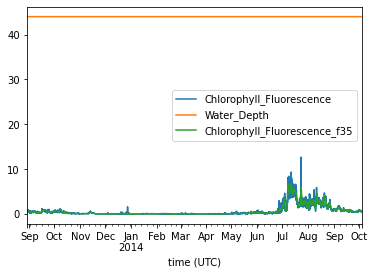

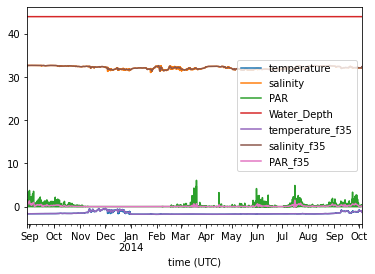

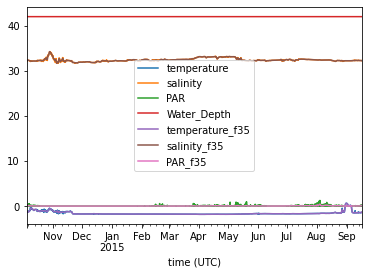

In [28]:
for dfn, df in dfs_filtered.items():
    df.drop(['depth','latitude','longitude'],axis=1).plot()


In [36]:
dfs_filtered.keys()

dict_keys(['datasets_Mooring_13ckp6a_final_filtered_ecf', 'datasets_Mooring_13ckp6a_final_filtered_sc', 'datasets_Mooring_14ckp6a_final_filtered_sc'])

/Users/bell/in_and_outbox/2020/mordy/C6/data/14CKP6A.csv
datasets_Mooring_14ckp6a_final_filtered_sc


<Figure size 600x1100 with 0 Axes>

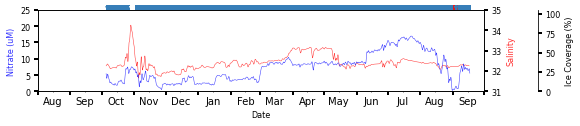

/Users/bell/in_and_outbox/2020/mordy/C6/data/13CKP6A.csv
datasets_Mooring_13ckp6a_final_filtered_ecf
datasets_Mooring_13ckp6a_final_filtered_sc


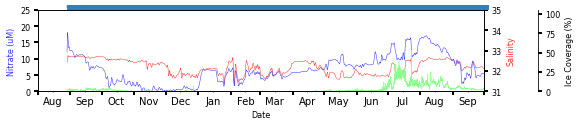

In [40]:
### modified from C2

##############################################################################
##############################################################################
def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
                sp.set_visible(False)
                
##############################################################################
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
##############################################################################
##############################################################################

#get nitrate data
data_dir = '/Users/bell/in_and_outbox/2020/mordy/C6/data/'

fig = plt.figure(figsize=(6,11),dpi=100)

for file in glob.glob(data_dir + '*.csv'):  #change file path you want to work from before running
    print(f"{file}")
    csv_file = open(file,'r')
    data = pd.read_csv(csv_file,na_values='1E+35',parse_dates=True,index_col='date_time')

    
    #and filter no3
    parameter = 'no3'
    ## missing data fill limited by number of hours to linearly interpolate
    temp = data[parameter].interpolate(method='time',limit=6)

    # get index of missing data that wasn't filled
    # the remaining missing data will continue to be missing after analysis
    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

    missing_index = np.isnan(temp)
    temp = data[parameter].interpolate(method='time')

    #address gaps at beginning and end... back fill... and forward fill at end... 
    # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
    temp.bfill(inplace=True)
    temp.ffill(inplace=True)

    #filter data with lanzcos filter
    data[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + data[parameter].mean()
    
    
    #GET MOORING ID FROM DATA FILE
    site = file.split('/')[-1].split('.csv')[0].lower()
    
    #merge filtered and unfiltered data... resample to hourly and linearly interpolate (non-issue since 1hr and already filtered)
    merged_df = pd.DataFrame()
    for df in dfs_filtered.keys():
        if site in df:
            print(df)
            merged_df = pd.concat([merged_df,dfs_filtered[df]])
    merged_df = merged_df.resample('1H').mean().interpolate()
    

    
    #Values that set the size and location of the water type bar at the top of the plot
    wtmark = 10
    wtval = 35 + (0.0124 * wtmark + 0.028)
    #wtval = 35.08
    
    #Definitions of water types are from Danielson SL, A comparison between late  
    #summer 2012 and 2013 water masses, macronutrients, and phytoplankton standing  
    #crops in the northern Bering and Chukchi Seas, 2017.
    
    #Brine Rejection / cold winter water is <-1 DegC and >33.6 PSU but isn't in paper

    
    #pressure correction assumed constant (moorings actually between 35-45m deep)
    data['FreezingTemp'] = (-0.0575 + 1.710523E-3 * np.sqrt(np.abs(merged_df['salinity'])) - 2.154996E-4 * merged_df['salinity']) * merged_df['salinity'] - 7.53E-4 * (40)
    
    #Arctic Coastal Water
    merged_df['acw'] = np.where(((merged_df['salinity'] >= 20) & (merged_df['salinity'] < 32) & (merged_df['temperature'] >= 7) & (merged_df['temperature'] < 12)), wtval, np.nan)
    #Bering Chukchi Winter Water
    merged_df['ww'] = np.where(((merged_df['salinity'] >= 30) & (merged_df['salinity'] <= 33.6) & (merged_df['temperature'] >= -2) & (merged_df['temperature'] < 0)), wtval,np.nan)
    #Bering Chukchi Summer Water
    merged_df['bsw'] = np.where(((merged_df['salinity'] >= 30) & (merged_df['salinity'] <= 33.6) & (merged_df['temperature'] >= 0) & (merged_df['temperature'] < 7)), wtval, np.nan)
    #Melt Water
    merged_df['mw'] = np.where(((merged_df['salinity'] >= 25) & (merged_df['salinity'] < 30) & (merged_df['temperature'] >= -2) & (merged_df['temperature'] < 7)), wtval, np.nan)
    #definitions below vary from publications - CMORDY PersComm 6/18/2020
    #Atlantic Water
    merged_df['aw'] = np.where(((merged_df['salinity'] > 33.6) & (merged_df['salinity'] < 35) & (merged_df['temperature'] >= -1.7) & (merged_df['temperature'] < 1)), wtval, np.nan)
    #Brine Rejection Water/Winter Water
    merged_df['br'] = np.where(((merged_df['salinity'] > 33.6) & (merged_df['salinity'] < 35) & (merged_df['temperature'] >= -2) & (merged_df['temperature'] < -1.7)), wtval, np.nan)


    
    mName = site

    iyear = merged_df.index.year[0]


    fig, ax1 = plt.subplots(figsize=(8,1.5))
    #ax1 = plt.subplots()
    #ax1.figsize=(80,120)
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    
    ax3.spines['right'].set_position(('axes',1.12))
    make_patch_spines_invisible(ax3)
    ax3.spines['right'].set_visible(True)

    
    a1, =ax1.plot(data.index,data.no3_f35,color=lighten_color('b',.8),linestyle='-',linewidth=.5)
    try:
        a2, =ax1.plot(merged_df.index,merged_df.Chlorophyll_Fluorescence,color=lighten_color('g',.3),linestyle='-',linewidth=.5)
    except:
        pass
    a3, =ax2.plot(merged_df.index,merged_df.salinity_f35,color=lighten_color('r',.8),linestyle='-',linewidth=.5)
    """
    try:
        a4, =ax3.plot(data.index[~np.isnan(data.icecov)],data.icecov[~np.isnan(data.icecov)],color=lighten_color('k',.8),linestyle='-',linewidth=.5)
    except:
        a4, =ax3.plot(data.index[~np.isnan(data.ice)],data.ice[~np.isnan(data.ice)],color=lighten_color('k',.8),linestyle='-',linewidth=.5)
    """
    
    wm_color = 'b'
    wm_color_hex = ['#e41a1c','#377eb8','#ffffff','#984ea3','#ff7f00','#000000']
    wtkw = dict(markersize = 1, markeredgewidth=5,marker='_',clip_on=False)
    wt, =ax2.plot(merged_df.index,merged_df.bsw,color=wm_color_hex[0],**wtkw)
    wt, =ax2.plot(merged_df.index,merged_df.ww,color=wm_color_hex[1],**wtkw)
    wt, =ax2.plot(merged_df.index,merged_df.acw,color=wm_color_hex[4],**wtkw)
    wt, =ax2.plot(merged_df.index,merged_df.mw,color=wm_color_hex[3],**wtkw)
    wt, =ax2.plot(merged_df.index,merged_df.br,color=wm_color_hex[5],**wtkw)
    wt, =ax2.plot(merged_df.index,merged_df.aw,color=wm_color_hex[2],**wtkw)
    #dn, =ax1.plot(merged_df.index,merged_df.calno3,'k.',markersize=10)
    
    #Set axis ranges and tick intervals
    ax1.set_xlim([date(iyear,8,1),date((iyear+1),10,1)])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter(''))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.DayLocator(15))
    
    ax1.yaxis.set_ticks(np.arange(0,30,5))
    ax2.yaxis.set_ticks(np.arange(31,36,1))
    ax3.yaxis.set_ticks(np.arange(0,200,25))
    
    ax1.set_ylim(0,25)
    ax2.set_ylim(31,35)
    ax3.set_ylim(0,105)
    
    lfmt = dict(fontsize=8)
    ax1.set_xlabel('Date',**lfmt)
    ax1.set_ylabel('Nitrate (uM)',**lfmt)
    ax2.set_ylabel('Salinity',**lfmt)
    ax3.set_ylabel('Ice Coverage (%)',**lfmt)
    
    ax1.yaxis.label.set_color(a1.get_color())
    ax2.yaxis.label.set_color(a3.get_color())
    ax3.yaxis.label.set_color('k')
    
    tkw = dict(size=4, width=2, labelsize=8,colors='k')
    ax1.tick_params(axis='x', **tkw)
    ax1.tick_params(axis='x', which='minor',length=1)
    ax1.tick_params(axis='y', **tkw)
    ax2.tick_params(axis='y', **tkw)
    ax3.tick_params(axis='y', **tkw)

    ax1.set_zorder(ax2.get_zorder()+1)
    ax1.patch.set_visible(False)
    ax3.axes.get_yaxis().set_visible(True)
    
    
    plt.plot() 
    csv_file.close()
    
    plt.subplots_adjust(hspace=0.4)
    plt.savefig('plots/' + mName + '_timeseries_fno3_fsal_chlor.png',bbox_inches='tight',dpi=300,format='png')
    plt.savefig('plots/' + mName + '_timeseries_fno3_fsal_chlor.eps',format='eps',dpi=1000,bbox_inches='tight')
    plt.show()  